# Playing with model described in https://arxiv.org/abs/1610.02415 
# Using many code from https://github.com/maxhodak/keras-molecules
# Generating aspirin neighbours

In [1]:
import pandas as pd
import h5py
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from model import MoleculeVAE
#from molecules.utils import one_hot_array, one_hot_index, decode_smiles_from_indexes
from utils import encode_smiles, decode_latent_molecule, interpolate, get_unique_mols
# number of dimensions to represent the molecules
# as the model was trained with this number, any operation made with the model must share the dimensions.
latent_dim = 292


# trained_model 0.95 validation accuracy
# trained with 80% of ALL chembl molecules, validated on the other 20.
trained_model = 'chembl_23_model.h5'
charset_file = 'charset.json'

aspirin_smiles = 'CC(=O)Oc1ccccc1C(=O)O'

Using TensorFlow backend.


# Load model

In [2]:
# load charset and model
with open('charset.json', 'r') as outfile:
    charset = json.load(outfile)

model = MoleculeVAE()
model.load(charset, trained_model, latent_rep_size = latent_dim)

# Encode aspirin SMILES into it's latent representation
- Our aspirin now looks like a 292 dimension continuous array...

In [3]:
aspirin_latent = encode_smiles(aspirin_smiles, model, charset)
aspirin_latent

array([[  2.52213776e-02,  -1.00045100e-01,   8.96435603e-03,
          1.02277026e-01,   1.49936471e-02,   2.72260737e-02,
         -4.32932116e-02,  -2.14553438e-02,   4.52417247e-02,
          3.63878980e-02,   3.67061421e-02,   1.01031482e-01,
         -4.48107496e-02,  -2.47134883e-02,   1.17019676e-02,
          7.01156333e-02,   1.37316659e-02,  -4.00409363e-02,
          7.46124983e-02,   8.94253179e-02,  -1.79390553e-02,
         -1.09457910e-01,  -6.96514547e-03,   9.72745046e-02,
          4.23288196e-02,  -3.18835070e-03,   1.31374165e-01,
         -1.06214486e-01,  -1.73226073e-01,   4.92027029e-05,
         -3.85468341e-02,   4.89751995e-02,   1.04478756e-02,
         -5.32450527e-02,  -4.24904674e-02,   1.42784808e-02,
         -1.60613544e-02,   8.48964378e-02,   2.14751661e-02,
          2.19248049e-02,  -3.33547182e-02,   1.17983006e-01,
         -1.09217446e-02,  -4.43444513e-02,  -3.48613709e-02,
         -8.92058089e-02,  -2.78004073e-03,   3.47086601e-03,
        

# Silly check: Are we reconstructing our aspirin properly?
- Looks like we are able to convert aspirin SMILES to a 292 dimension array and go back from it, good!

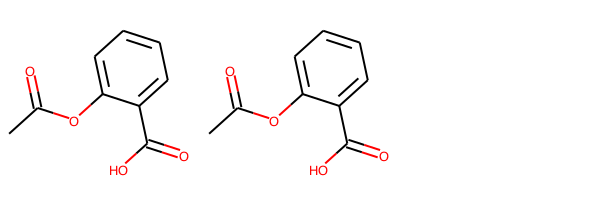

In [4]:
reconstructed_aspirin = decode_latent_molecule(aspirin_latent, model, charset, latent_dim)
original = Chem.MolFromSmiles(aspirin_smiles)
reconstructued = Chem.MolFromSmiles(reconstructed_aspirin)

Draw.MolsToGridImage([original, reconstructued])

# Generate 1k random latent mol representations with mean==aspirin, stdev==0.1

In [5]:
stdev = 0.1
latent_mols = stdev * np.random.randn(1000, latent_dim) + aspirin_latent

# Decode the randomly aspirin centered generated latent representations

In [6]:
decoded_molecules = []
for lm in latent_mols:
    decoded_molecules.append(decode_latent_molecule(lm, model, charset, latent_dim))

# Validate the molecules using RDKit

In [7]:
from rdkit import Chem
from rdkit import RDLogger

# remove warnings and errors from notebook (lots of them due non valid molecule generation)
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

working_mols = []
for smiles in decoded_molecules:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue

# Let's visualise the aspirinish molecules we artificially generated!

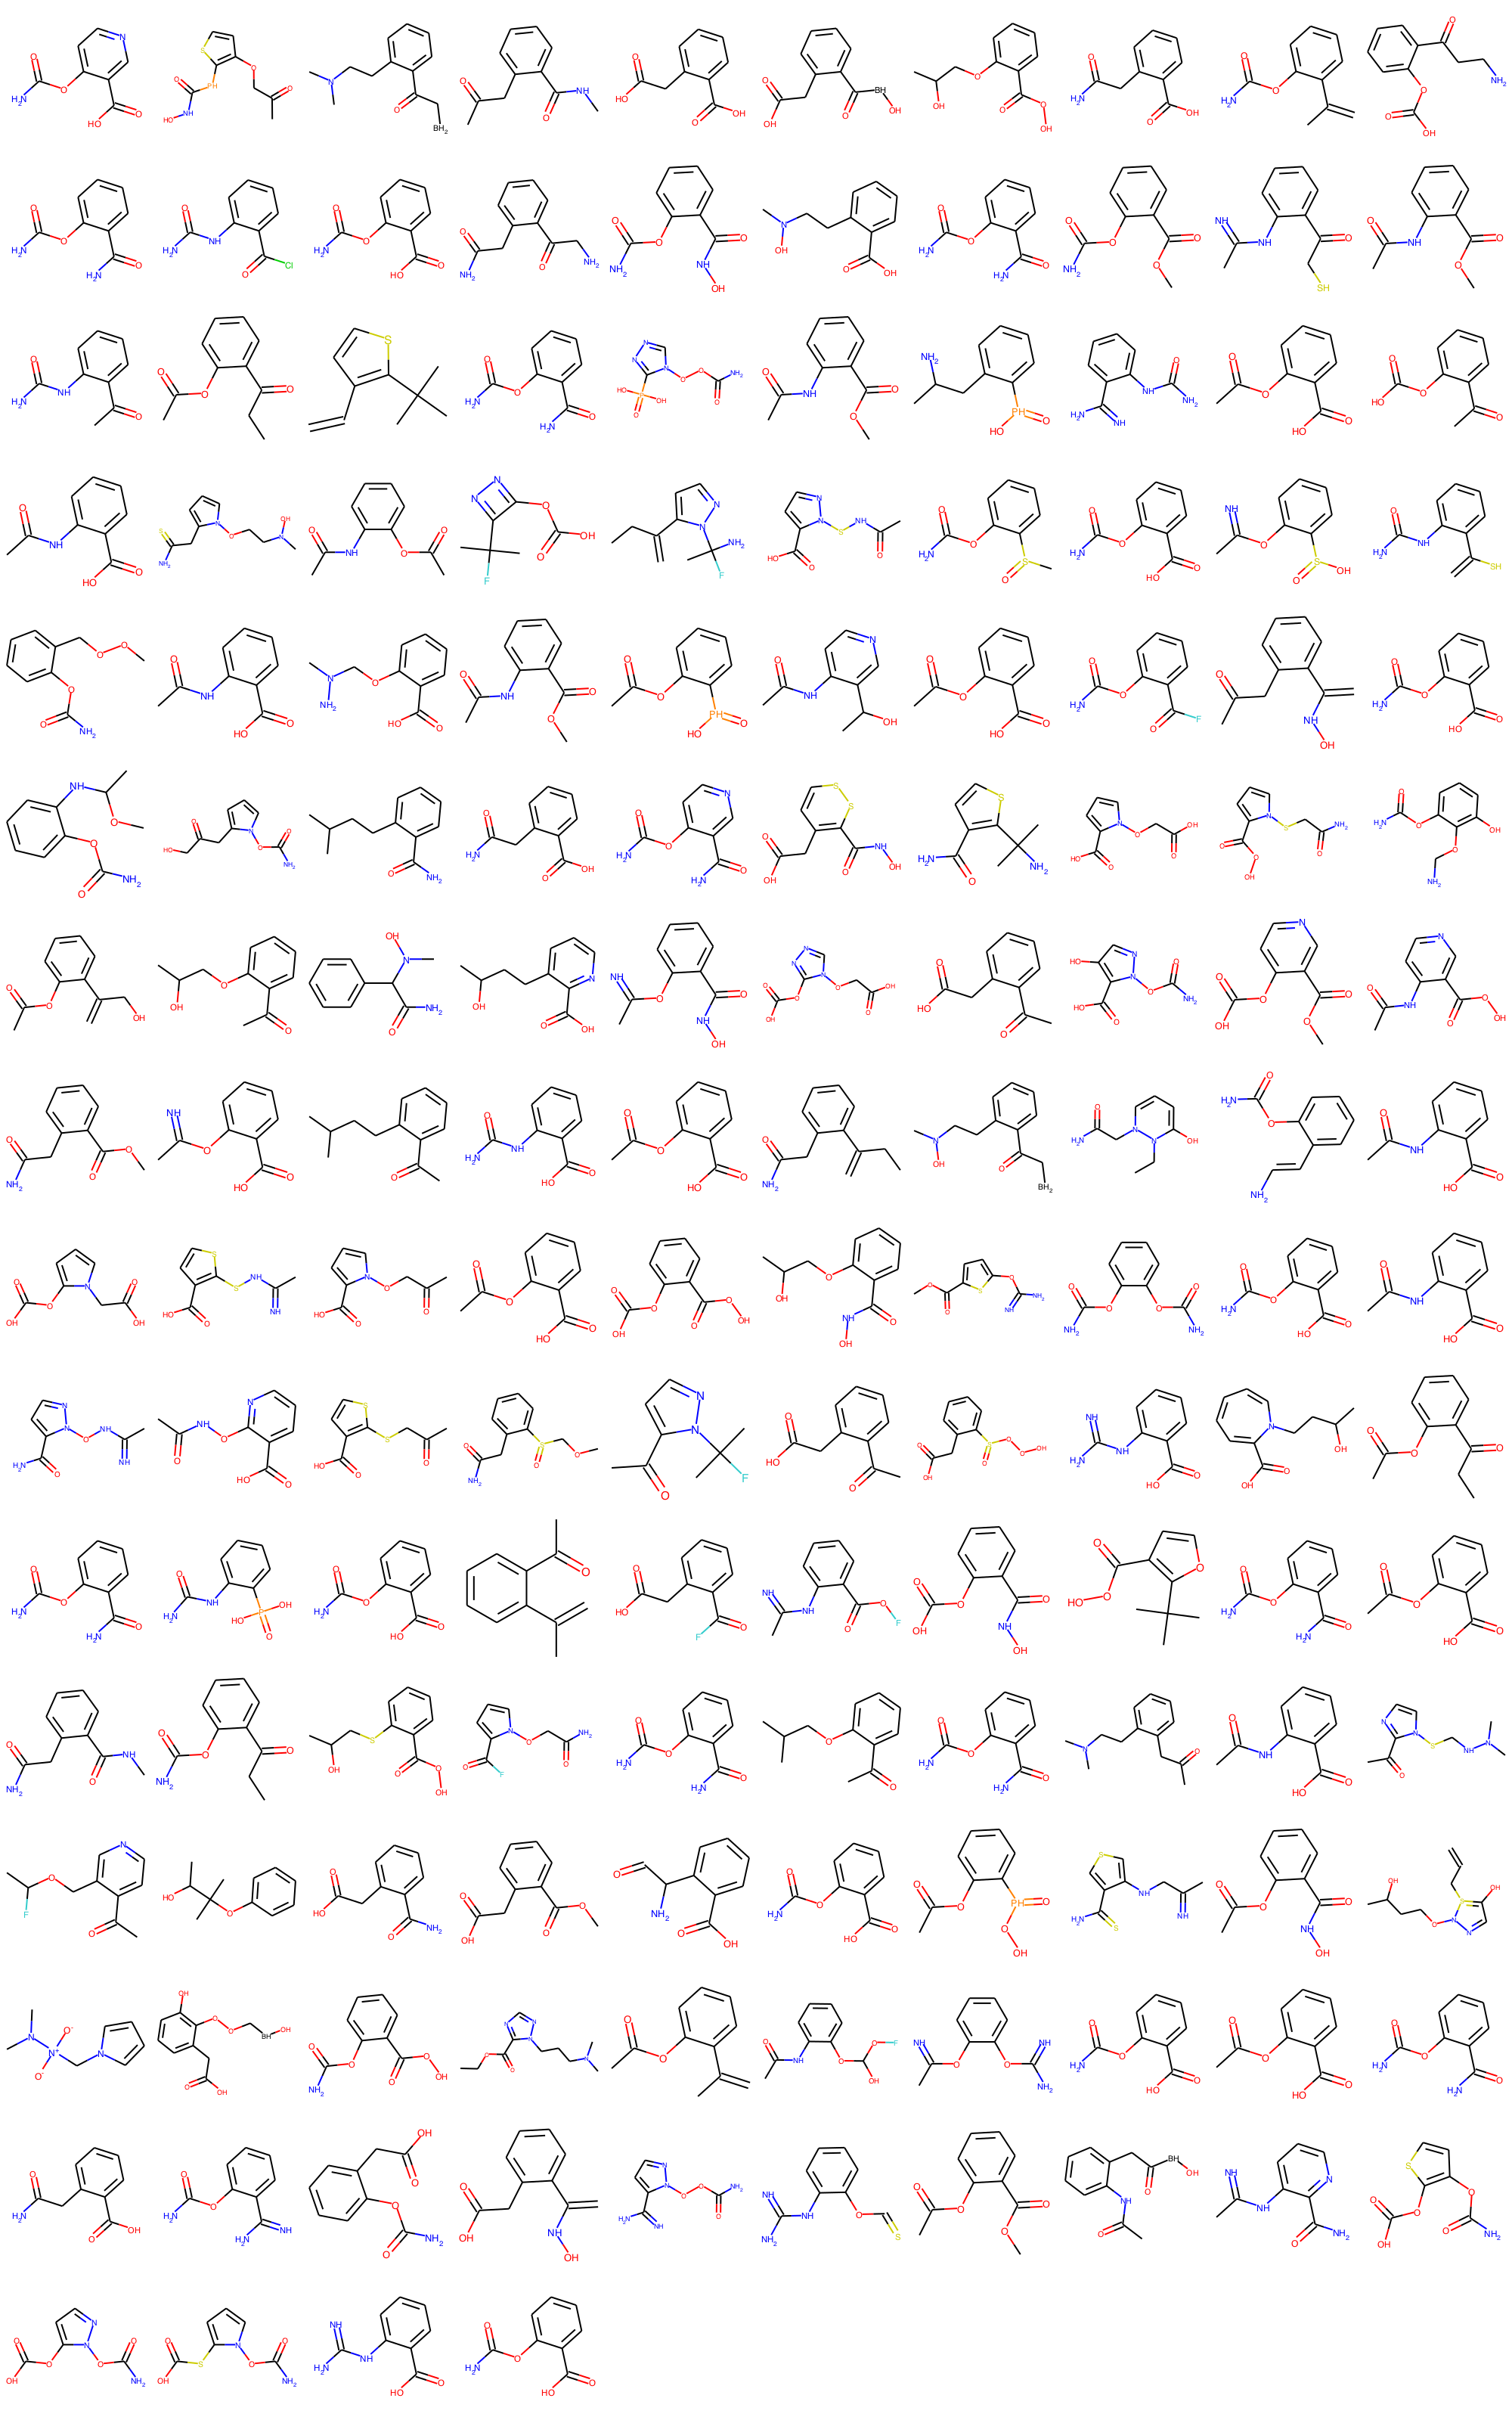

In [8]:
Draw.MolsToGridImage([mol for mol in working_mols], molsPerRow=10)

# Check how many of them we can find using UniChem 

In [9]:
import requests

url = 'https://www.ebi.ac.uk/unichem/rest/inchikey/{}'

unique_mols = get_unique_mols(working_mols)

in_unichem = []
for um in unique_mols:
    res = requests.get(url.format(um[1]))
    if res.status_code == 200:
        in_unichem.append([um[0], res.json()])

not_in_chembl = filter(lambda mol: 1 not in [int(res['src_id']) for res in mol[1]], in_unichem)

print "rdkit valid mols:", len(working_mols)
print "unique molecules:", len(unique_mols)
print "found in unichem:", len(in_unichem)
print "not in chembl:", len(not_in_chembl)

rdkit valid mols: 154
unique molecules: 124
found in unichem: 35
not in chembl: 30


# Show mols found in unichem and not in chembl

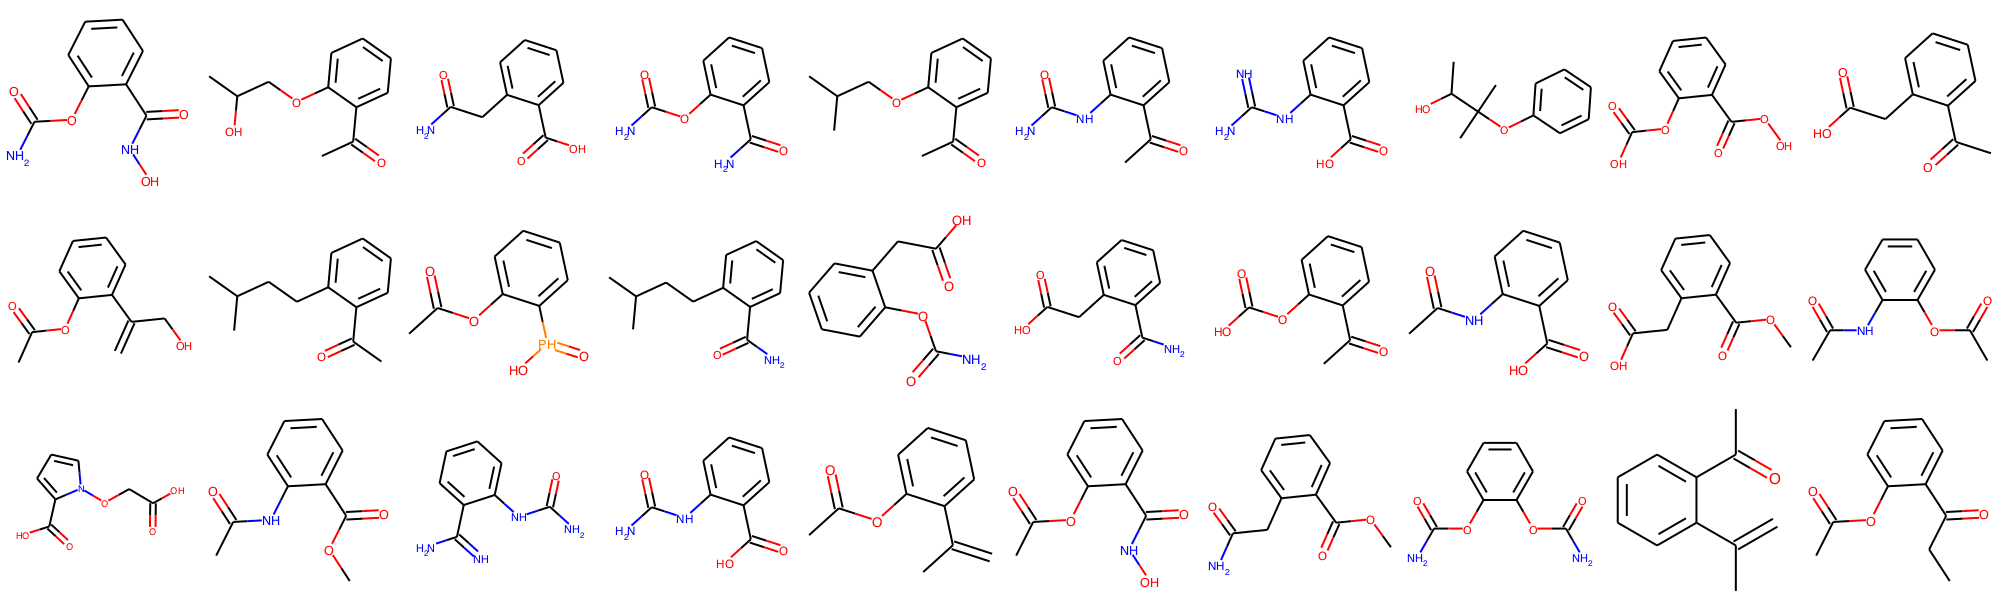

In [10]:
Draw.MolsToGridImage([mol[0] for mol in not_in_chembl], molsPerRow=10)

# Interpolation of two molecules
- Let's make a linear interpolation from paracetamol to aspirin latent molecules and let's check what we got...
- Looks like is not a great idea to navigate from one molecule to another using linear space...

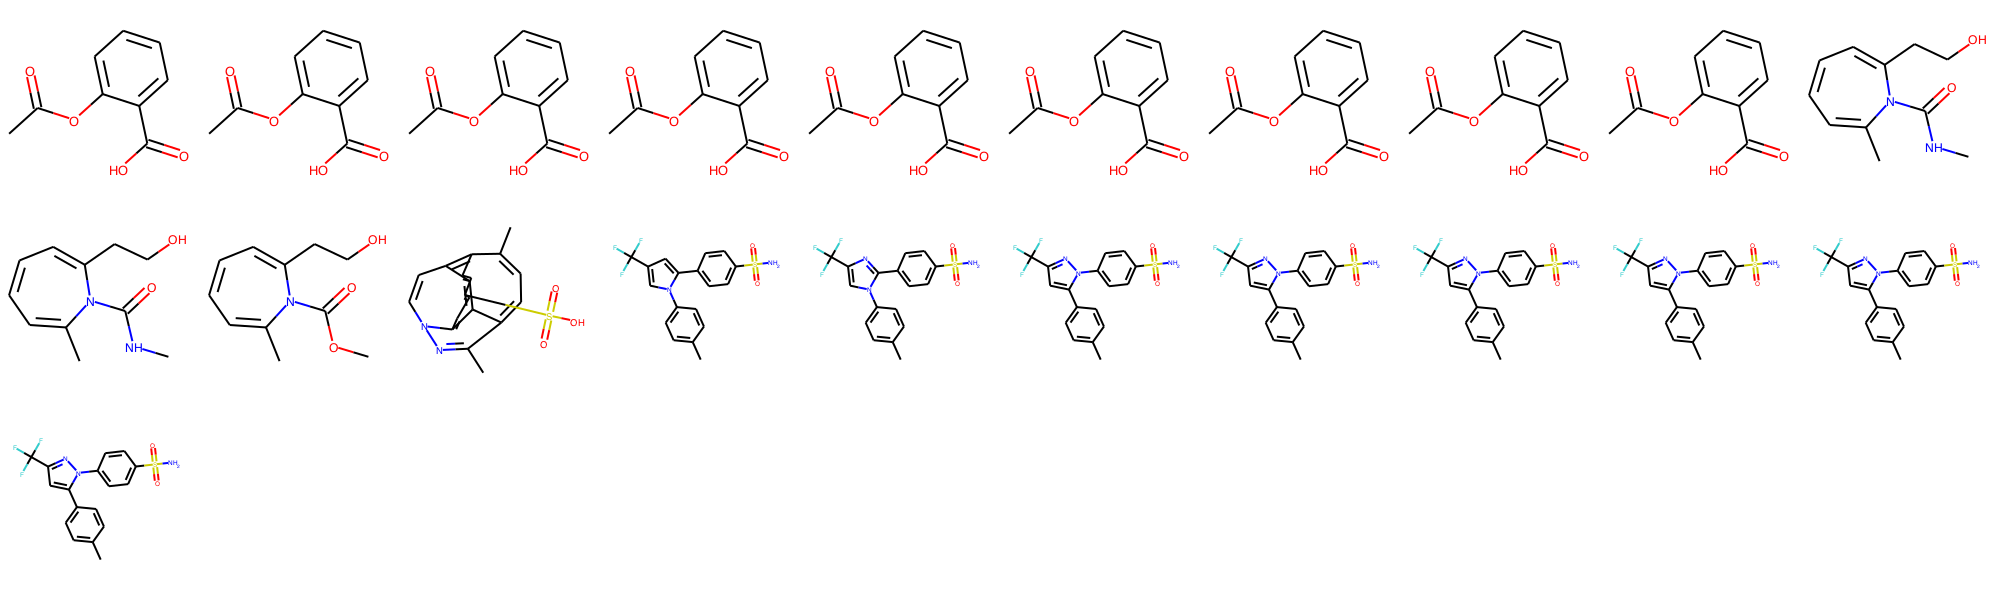

In [ ]:
paracetamol_smiles = 'CC(=O)Nc1ccc(O)cc1'
celecoxib_smiles = 'Cc1ccc(cc1)c2cc(nn2c3ccc(cc3)S(=O)(=O)N)C(F)(F)F'

steps = 100
results = interpolate(aspirin_smiles, celecoxib_smiles, steps, charset, model, latent_dim)

working_results = []
for smiles in results:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_results.append(mol)
    except:
        continue
                
Draw.MolsToGridImage(working_results, molsPerRow=10)

# Optimise molecules given a property (alogp, qed...)

In [ ]:
from bayes_opt import BayesianOptimization
from rdkit import Chem
from rdkit.Chem import Descriptors


def target_fuction(**kwargs):
    lm = np.array([x[1] for x in sorted(kwargs.items(), key=lambda x: int(x[0]))])
    smiles = decode_latent_molecule(lm, model, charset, latent_dim)
    try:
        mol = Chem.MolFromSmiles(smiles)
        ret = Descriptors.MolLogP(mol)
    except:
        ret = -1
    return ret
    
bo = BayesianOptimization(target_fuction,
                          dict((str(key), (value - 0.1, value + 0.1)) for (key, value) in enumerate(aspirin_latent[0])),
                          verbose=0)


bo.explore(dict((str(key), [value]) for (key, value) in enumerate(aspirin_latent[0])))
bo.maximize(init_points=20, n_iter=15, kappa=2)

# The output values can be accessed with self.res
print(bo.res['all'])